In [16]:
from datetime import datetime
import json
import os

from IPython.display import JSON
import numpy as np
import pandas as pd
import seaborn as sns
import s3fs

os.environ['AWS_PROFILE'] = 'waisman-admin'


In [ ]:
s3 = s3fs.S3FileSystem()
def convert_json(s):
    s = s.replace('\'', '"').replace('False', 'false').replace('True', 'true')
    s_json = json.loads(s)
    s_json['Timestamp'] = datetime.strptime(s_json['Timestamp'], '%Y-%m-%d %H:%M:%S.%f')  # Convert to datetime
    return s_json
with s3.open('s3://nkalafut-celltrip/3gpu-3learn-3run.log', 'r') as f:
    records = f.read().split('\n')
    records = [convert_json(record) for record in records if len(record) > 0]


In [56]:
# Generate df
df = pd.DataFrame(records)
df = pd.concat((df.drop(columns='Itemized Reward'), pd.json_normalize(df['Itemized Reward'])), axis=1)
begin_time = df.loc[df['Event Type']=='Register Workers', 'Timestamp'].item()
df['Timestamp'] = df['Timestamp'].apply(lambda t: (t-begin_time).total_seconds() / 60**2)  # Hours


In [ ]:
df.columns


Index(['Timestamp', 'Event Type', 'Policy Iteration', 'Stage', 'Rank',
       'Timesteps', 'Memories', 'Reward', 'Time', 'memory', 'VRAM',
       'New Memories', 'Replay Memories', 'Total Memories', 'Mean Losses',
       'Action STD', 'Inherited', 'distance', 'origin', 'bound', 'velocity',
       'action'],
      dtype='object')

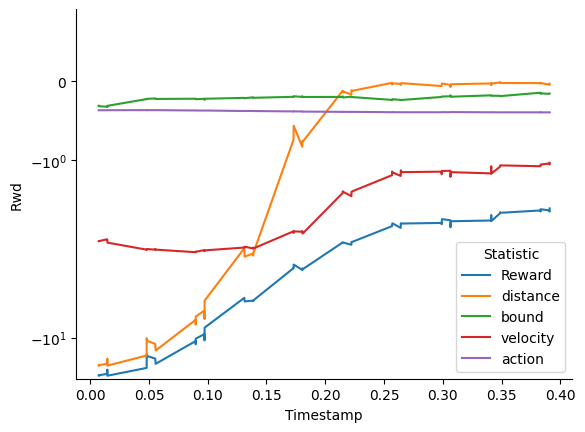

In [73]:
df_melt = df.loc[
    df['Event Type']=='Rollout',
    ['Timestamp', 'Reward', 'distance',  # 'origin',
     'bound', 'velocity', 'action']].melt(
         id_vars='Timestamp', var_name='Statistic',
         value_name='Rwd')
ax = sns.lineplot(df_melt, x='Timestamp', y='Rwd', hue='Statistic')
sns.despine()
ax.set_yscale('symlog')


<Axes: xlabel='Timestamp', ylabel='Reward'>

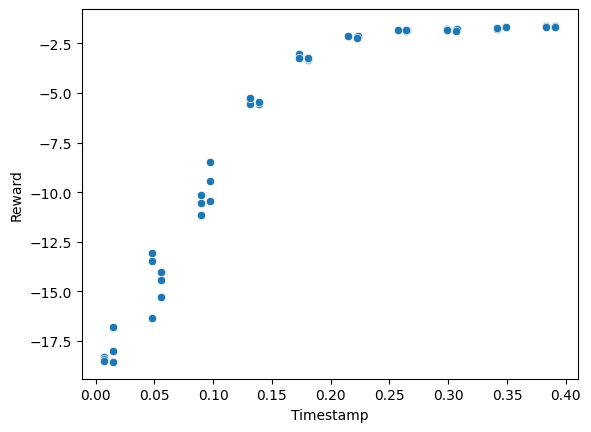

In [ ]:
sns.scatterplot(df.loc[df['Event Type']=='Rollout'], x='Timestamp', y='Reward')


In [ ]:
# TODO: Parse JSON string
JSON(records)


<IPython.core.display.JSON object>